# DeiT Base 모델을 활용한 패치 단위 Saliency 분포 분석

## 📘 개요 (Overview)
이 노트북에서는 **Data-free Model Inversion(DMI)** 으로 생성된 이미지들에 대해  
**DeiT-Base Patch16 (ImageNet pretrained)** 모델을 이용하여 **패치 단위(patch-wise) saliency map**을 계산하고,  
전체 데이터셋의 saliency 분포를 분석하는 것을 목표로 합니다.

본 분석의 주요 목적은 다음과 같습니다:

1. **히스토그램 분석**
   - 각 이미지에서 계산된 saliency 값을 [0, 1] 범위로 정규화합니다.
   - bin 크기가 0.1인 총 10개의 구간으로 히스토그램을 계산합니다.
   - 각 saliency 범위에 속하는 **패치 수**를 bar plot으로 시각화합니다.
   - 예상 결과: 대부분의 패치가 낮은 saliency 값을 가지며, 높은 saliency는 극히 적은 **long-tail 분포** 형태.

2. **누적 파워-로우 (Power-Law) 곡선 분석**
   - 전체 패치 saliency 값을 내림차순으로 정렬합니다.
   - 패치 수의 누적 비율 대비, saliency 누적 비율을 그래프로 표현합니다.
   - “상위 몇 % 패치가 전체 saliency의 몇 %를 차지하는가?”를 확인할 수 있습니다.

---

## 📂 데이터셋 구조
분석 대상 이미지는 다음 경로에 위치합니다:
```
./dataset/deit_base_16_imagenet/DMI_Seed/
├── DMI-4000-0-32-W4A8/
│ ├── *.png (32장)
├── DMI-4000-1-32-W4A8/
│ ├── *.png
├── ...
├── DMI-4000-50-32-W4A8/
```
- seed는 `0–50` 범위  
- 각 seed 폴더에 **32장의 이미지**  
- 총 이미지 수: 51 × 32 = **1,632장**

---

## 🧠 Teacher 모델
다음 DeiT 기반 모델을 사용합니다:


모델 로딩 함수:
```python
teacher = get_teacher("deit_base_16_imagenet")
```

In [34]:
# ==============================
# Cell 2 — 라이브러리 import & 환경 설정
# ==============================

import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt

# ------------------------------
# GPU 선택 (3번 GPU 사용)
# ------------------------------
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------------
# 재현성(Reproducibility) 설정
# ------------------------------
torch.manual_seed(0)
np.random.seed(0)

# ------------------------------
# matplotlib 기본 설정
# ------------------------------
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

print("Environment setup completed.")


Using device: cuda
Environment setup completed.


In [35]:
# ==============================
# Cell 3 — 실험 설정(Config) 정의
# ==============================

# ------------------------------
# 데이터셋 기본 경로
# ------------------------------
BASE_DIR = "./dataset/deit_base_16_imagenet/SMI_Seed"

# ------------------------------
# seed 범위: 0 ~ 50 (총 51개)
# ------------------------------
SEED_RANGE = range(1, 51)

# ------------------------------
# 모델 이름 설정 (teacher 모델)
# ------------------------------
MODEL_NAME = "deit_base_16_imagenet"

# ------------------------------
# saliency histogram bin 설정
# 0.0 ~ 1.0 구간을 0.1 간격으로 나누면 총 10개 bins
# ------------------------------
BIN_EDGES = np.linspace(0.0, 1.0, 11)  # [0.0, 0.1, ..., 1.0]

# ------------------------------
# 디버깅 모드 옵션
# True → 일부 이미지만 처리 (빠르게 테스트)
# False → 전체 데이터셋 처리
# ------------------------------
DEBUG_MODE = False
DEBUG_MAX_IMAGES = 20

# ------------------------------
# 출력 폴더 설정 (결과 저장용)
# ------------------------------
OUTPUT_DIR = "./observation/06_Saliency_Analysis/SMI"
# OUTPUT_DIR = "./observation/06_Saliency_Analysis/SMI"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Configuration loaded:")
print(f"- Base directory: {BASE_DIR}")
print(f"- Seeds: 1 to 50 ({len(SEED_RANGE)} seeds)")
print(f"- Model name: {MODEL_NAME}")
print(f"- Histogram bins: {BIN_EDGES}")
print(f"- Debug mode: {DEBUG_MODE}")

Configuration loaded:
- Base directory: ./dataset/deit_base_16_imagenet/SMI_Seed
- Seeds: 1 to 50 (50 seeds)
- Model name: deit_base_16_imagenet
- Histogram bins: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
- Debug mode: False


In [36]:
# ==============================
# 새 Cell — seed별 targets 로딩 & path_to_target 매핑
# ==============================

import json

TARGET_BASE_DIR = "./observation/06_Saliency_Analysis/targets"

path_to_target = {}
missing_target_paths = []

for seed in SEED_RANGE:
    # folder_name = f"DMI-4000-{seed}-32-W4A8"
    folder_name = f"SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-{seed}-32-W4A8"
    folder_path = os.path.join(BASE_DIR, folder_name)
    img_paths = sorted(glob.glob(os.path.join(folder_path, "*.png")))
    
    if len(img_paths) == 0:
        print(f"⚠️ Seed {seed}: 이미지가 없습니다. ({folder_path})")
        continue

    target_file = os.path.join(TARGET_BASE_DIR, f"saliency_seed_{seed}.txt")
    if not os.path.isfile(target_file):
        print(f"⚠️ Seed {seed}: 타겟 파일이 없습니다. ({target_file}) → 이 seed는 argmax로 saliency 계산 예정")
        # 이 seed에 대해서는 나중에 argmax를 쓰고 싶다면, 여기서 None 등록
        for p in img_paths:
            path_to_target[p] = None
            missing_target_paths.append(p)
        continue

    # JSON 형식으로 로드
    with open(target_file, "r") as f:
        data = json.load(f)

    targets_seed = data.get("targets", None)
    if targets_seed is None:
        print(f"⚠️ Seed {seed}: 파일에 'targets' 키가 없습니다. ({target_file})")
        for p in img_paths:
            path_to_target[p] = None
            missing_target_paths.append(p)
        continue

    if len(targets_seed) != len(img_paths):
        print(f"⚠️ Seed {seed}: 타겟 개수({len(targets_seed)})와 이미지 개수({len(img_paths)})가 다릅니다.")
        min_len = min(len(targets_seed), len(img_paths))
        print(f"   → 앞 {min_len}개만 매핑합니다.")
    else:
        min_len = len(img_paths)

    for img_path, t in zip(img_paths[:min_len], targets_seed[:min_len]):
        path_to_target[img_path] = int(t)

print("-" * 60)
print(f"총 매핑된 이미지 개수: {len(path_to_target)}")
print(f"타겟이 없는(missing) 이미지 개수: {len(missing_target_paths)}")
print("샘플 5개 매핑 예시:")
for p in list(path_to_target.keys())[:5]:
    print(" ", p, "→", path_to_target[p])


------------------------------------------------------------
총 매핑된 이미지 개수: 1600
타겟이 없는(missing) 이미지 개수: 0
샘플 5개 매핑 예시:
  ./dataset/deit_base_16_imagenet/SMI_Seed/SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-1-32-W4A8/0-0.png → 6
  ./dataset/deit_base_16_imagenet/SMI_Seed/SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-1-32-W4A8/0-1.png → 16
  ./dataset/deit_base_16_imagenet/SMI_Seed/SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-1-32-W4A8/0-10.png → 30
  ./dataset/deit_base_16_imagenet/SMI_Seed/SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-1-32-W4A8/0-11.png → 71
  ./dataset/deit_base_16_imagenet/SMI_Seed/SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-1-32-W4A8/0-12.png → 72


In [37]:
# ==============================
# target별 이미지 개수 통계 저장 코드
# ==============================

from collections import defaultdict
import json
import os

# 저장할 경로
TARGET_STATS_PATH = os.path.join(OUTPUT_DIR, "target_stats.json")

# target_class → count
target_count = defaultdict(int)

# target_class → 이미지 리스트(옵션)
target_to_paths = defaultdict(list)

for img_path, target_class in path_to_target.items():
    # target_class=None 은 제외하거나 별도 처리
    if target_class is None:
        continue

    target_count[target_class] += 1
    target_to_paths[target_class].append(img_path)

# JSON 저장 형식 구성
target_stats = {
    "num_classes": len(target_count),
    "counts": target_count,  # label마다 몇 장인지
    "paths_per_label": target_to_paths  # label → 이미지 경로 리스트 (원하면 삭제 가능)
}

# defaultdict는 JSON 직렬화가 안 되므로 dict로 변환
target_stats["counts"] = dict(target_stats["counts"])
target_stats["paths_per_label"] = {int(k): v for k, v in target_stats["paths_per_label"].items()}

# 파일로 저장
with open(TARGET_STATS_PATH, "w") as f:
    json.dump(target_stats, f, indent=4)

print(f"Target별 이미지 개수를 다음 파일에 저장했습니다:\n  {TARGET_STATS_PATH}")

# 통계 요약
print("\n📊 label별 이미지 개수 일부 예시:")
for label, cnt in list(target_stats["counts"].items())[:10]:
    print(f"  class {label}: {cnt} images")


Target별 이미지 개수를 다음 파일에 저장했습니다:
  ./observation/06_Saliency_Analysis/SMI/target_stats.json

📊 label별 이미지 개수 일부 예시:
  class 6: 1 images
  class 16: 4 images
  class 30: 4 images
  class 71: 4 images
  class 72: 3 images
  class 79: 2 images
  class 122: 3 images
  class 137: 1 images
  class 138: 4 images
  class 145: 3 images


In [38]:
# ==============================
# Cell 4 — Teacher 모델 로딩
# ==============================

from utils import build_model

def get_teacher(name):
    teacher_name = {'deit_tiny_16_imagenet': 'deit_tiny_patch16_224',
                    'deit_base_16_imagenet': 'deit_base_patch16_224',
                    }
    if name.split("_")[-1]=='imagenet':
        teacher=build_model(teacher_name[name], Pretrained=True)
    else:
        raise NotImplementedError
    return teacher

# ------------------------------
# Teacher 모델 로딩
# ------------------------------
print(f"Loading teacher model: {MODEL_NAME}")
teacher = get_teacher(MODEL_NAME)

# 디바이스로 이동 (Cell 2에서 정의한 device 사용)
teacher = teacher.to(device)

# 평가 모드로 설정
teacher.eval()

# saliency 계산을 위해 gradient가 필요하다면 파라미터 grad 활성화
for p in teacher.parameters():
    p.requires_grad = True

# ------------------------------
# 모델 정보 출력
# ------------------------------
num_params = sum(p.numel() for p in teacher.parameters())
num_params_m = num_params / 1e6

print(f"Teacher model loaded on device: {device}")
print(f"#Params: {num_params_m:.2f}M ({num_params:,} parameters)")


Loading teacher model: deit_base_16_imagenet
Teacher model loaded on device: cuda
#Params: 86.57M (86,567,656 parameters)


In [39]:
# ==============================
# Cell 5 — 이미지 경로 수집 & 데이터셋 인덱싱
# ==============================

image_paths = []

for seed in SEED_RANGE:
    # folder_name = f"DMI-4000-{seed}-32-W4A8"
    folder_name = f"SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-{seed}-32-W4A8"
    folder_path = os.path.join(BASE_DIR, folder_name)
    
    if not os.path.isdir(folder_path):
        print(f"⚠️ 폴더가 존재하지 않습니다: {folder_path}")
        continue
    
    # 해당 seed 폴더 내의 모든 PNG 이미지 수집
    pattern = os.path.join(folder_path, "*.png")
    paths_in_folder = sorted(glob.glob(pattern))
    
    if len(paths_in_folder) == 0:
        print(f"⚠️ 이미지가 없는 폴더입니다: {folder_path}")
    else:
        print(f"Seed {seed:2d}: {len(paths_in_folder)} images")
    
    image_paths.extend(paths_in_folder)

# 전체 이미지 개수 출력
num_images_total = len(image_paths)
print("-" * 50)
print(f"총 이미지 개수 (수집된 경로 기준): {num_images_total}")

# 디버깅 모드일 경우, 일부만 사용
if DEBUG_MODE:
    original_count = len(image_paths)
    image_paths = image_paths[:DEBUG_MAX_IMAGES]
    print(f"DEBUG_MODE = True → {original_count}개 중 상위 {len(image_paths)}개 이미지만 사용합니다.")

# 샘플 경로 몇 개 출력
print("-" * 50)
print("샘플 이미지 경로 5개 예시:")
for p in image_paths[:5]:
    print("  ", p)


Seed  1: 32 images
Seed  2: 32 images
Seed  3: 32 images
Seed  4: 32 images
Seed  5: 32 images
Seed  6: 32 images
Seed  7: 32 images
Seed  8: 32 images
Seed  9: 32 images
Seed 10: 32 images
Seed 11: 32 images
Seed 12: 32 images
Seed 13: 32 images
Seed 14: 32 images
Seed 15: 32 images
Seed 16: 32 images
Seed 17: 32 images
Seed 18: 32 images
Seed 19: 32 images
Seed 20: 32 images
Seed 21: 32 images
Seed 22: 32 images
Seed 23: 32 images
Seed 24: 32 images
Seed 25: 32 images
Seed 26: 32 images
Seed 27: 32 images
Seed 28: 32 images
Seed 29: 32 images
Seed 30: 32 images
Seed 31: 32 images
Seed 32: 32 images
Seed 33: 32 images
Seed 34: 32 images
Seed 35: 32 images
Seed 36: 32 images
Seed 37: 32 images
Seed 38: 32 images
Seed 39: 32 images
Seed 40: 32 images
Seed 41: 32 images
Seed 42: 32 images
Seed 43: 32 images
Seed 44: 32 images
Seed 45: 32 images
Seed 46: 32 images
Seed 47: 32 images
Seed 48: 32 images
Seed 49: 32 images
Seed 50: 32 images
--------------------------------------------------

In [40]:
# ==============================
# Cell 6 — 이미지 전처리 & saliency 계산 유틸 함수 정의
# ==============================

from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F

# ------------------------------
# DeiT 입력용 전처리 설정 (ImageNet 기준)
# ------------------------------
IMG_SIZE = 224

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# ------------------------------
# 1) 이미지 로딩 & 전처리
# ------------------------------
def load_image_pil(img_path: str) -> Image.Image:
    """PNG 파일 경로에서 PIL 이미지를 로드합니다."""
    img = Image.open(img_path).convert("RGB")
    return img

def preprocess_image(pil_img: Image.Image) -> torch.Tensor:
    """
    PIL 이미지를 DeiT 입력 형태 (1, 3, H, W) 텐서로 변환합니다.
    - 크기: 224 x 224
    - 정규화: ImageNet mean/std
    """
    x = transform(pil_img)          # (3, H, W)
    x = x.unsqueeze(0).to(device)   # (1, 3, H, W)
    return x

# ------------------------------
# 2) Grad 기반 saliency map 계산 (patch-wise 근사) - 수정 버전
# ------------------------------
PATCH_GRID_SIZE = 14          # 224 / 16 = 14 (DeiT-base patch grid)
NUM_PATCHES = PATCH_GRID_SIZE * PATCH_GRID_SIZE  # 196

def compute_saliency_map(teacher, x: torch.Tensor, target_class: int = None) -> np.ndarray:
    """
    Grad 기반 saliency map을 계산합니다.
    - 입력 x: (1, 3, H, W)
    - 출력: (PATCH_GRID_SIZE, PATCH_GRID_SIZE) 형태의 patch-wise saliency (예: 14x14)
    
    이 모델은 forward 시
      teacher(x, current_abs_index, next_relative_index)
    형태를 요구하므로, num_patches에 맞는 index 텐서를 생성해 함께 전달합니다.
    """
    teacher.zero_grad()
    if x.grad is not None:
        x.grad.zero_()

    # 입력 텐서에 grad가 붙도록 새로 만들기 (shared grad 문제 방지용)
    x = x.detach().clone().requires_grad_(True)

    batch_size = x.size(0)
    # num_patches 길이의 index 텐서 생성 (배치마다 동일한 index)
    patch_idx = torch.arange(NUM_PATCHES, device=x.device).long()  # (196,)
    patch_idx = patch_idx.unsqueeze(0).repeat(batch_size, 1)       # (B, 196)

    # Forward (모델 시그니처에 맞게 인자 전달)
    # teacher가 반환하는 첫 번째 값이 logits이라고 가정
    outputs = teacher(x, patch_idx, patch_idx)
    if isinstance(outputs, (tuple, list)):
        logits = outputs[0]  # t_out
    else:
        logits = outputs     # 혹시나 하나만 반환하는 경우

    # 타겟 클래스 설정: None이면 argmax 사용
    if target_class is None:
        target_class = logits.argmax(dim=1).item()

    loss = logits[0, target_class]
    loss.backward()

    # 입력에 대한 gradient: (1, 3, H, W)
    grad = x.grad.detach()  # (1, 3, H, W)

    # 채널 방향 max-norm saliency: (1, 1, H, W)
    saliency_pixel = grad.abs().max(dim=1, keepdim=True)[0]  # (1, 1, H, W)

    # patch grid 크기(PATCH_GRID_SIZE x PATCH_GRID_SIZE)로 average pooling
    saliency_patch = F.adaptive_avg_pool2d(
        saliency_pixel, output_size=(PATCH_GRID_SIZE, PATCH_GRID_SIZE)
    )  # (1, 1, 14, 14)

    saliency_patch = saliency_patch[0, 0].cpu().numpy()  # (14, 14)
    return saliency_patch


# ------------------------------
# 3) Saliency 정규화 & flatten
# ------------------------------
def normalize_and_flatten_saliency(saliency_2d: np.ndarray) -> np.ndarray:
    """
    2D saliency map을 [0, 1] 범위로 정규화한 뒤, 1D 벡터로 flatten합니다.
    """
    s = saliency_2d.astype(np.float32)
    s_min = s.min()
    s_max = s.max()
    if s_max - s_min < 1e-12:
        # 모든 값이 동일한 경우, 전부 0으로 두거나 0.5 등으로 설정 가능
        # 여기서는 모두 0으로 설정
        s_norm = np.zeros_like(s)
    else:
        s_norm = (s - s_min) / (s_max - s_min)
    return s_norm.flatten()  # (num_patches,)

# ------------------------------
# 4) 한 이미지에 대해 patch-wise saliency 벡터 얻기
# ------------------------------
def get_patch_saliency_from_image(img_path: str,
                                  teacher,
                                  target_class: int | None = None):
    """
    단일 이미지 경로에 대해:
      - 이미지 로딩
      - 전처리
      - grad 기반 patch-wise saliency 계산 (target_class가 주어지면 해당 클래스 기준)
      - [0,1] 정규화 & flatten
    
    반환:
      saliency_flat: (num_patches,) numpy array
      pil_img: 원본 PIL 이미지
      saliency_2d: (PATCH_GRID_SIZE, PATCH_GRID_SIZE) 2D saliency map
    """
    pil_img = load_image_pil(img_path)
    x = preprocess_image(pil_img)

    saliency_2d = compute_saliency_map(teacher, x, target_class=target_class)
    saliency_flat = normalize_and_flatten_saliency(saliency_2d)
    return saliency_flat, pil_img, saliency_2d


# ------------------------------
# 5) DEBUG용 시각화 저장 함수
# ------------------------------
def save_debug_visualizations(pil_img: Image.Image,
                              saliency_2d: np.ndarray,
                              save_prefix: str):
    """
    DEBUG 모드에서 사용할 시각화 저장 함수.
    - 원본 이미지 (224x224)
    - saliency heatmap
    - 원본 + saliency overlay
    를 각각 PNG 파일로 저장합니다.
    
    save_prefix 예시:
      save_prefix = os.path.join(OUTPUT_DIR, "debug_seed0_img000")
    그러면:
      debug_seed0_img000_orig.png
      debug_seed0_img000_saliency.png
      debug_seed0_img000_overlay.png
    등이 저장됩니다.
    """
    # 1) 원본 이미지 (전처리와 동일하게 224x224로 리사이즈)
    img_resized = pil_img.resize((IMG_SIZE, IMG_SIZE))
    orig_path = f"{save_prefix}_orig.png"
    img_resized.save(orig_path)

    # 2) saliency heatmap (0~1 정규화)
    s = saliency_2d.astype(np.float32)
    s_min, s_max = s.min(), s.max()
    if s_max - s_min < 1e-12:
        s_norm = np.zeros_like(s)
    else:
        s_norm = (s - s_min) / (s_max - s_min)

    heatmap_path = f"{save_prefix}_saliency.png"
    plt.figure()
    plt.imshow(s_norm, cmap="jet")
    plt.colorbar(label="Normalized saliency")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(heatmap_path, bbox_inches="tight", pad_inches=0)
    plt.close()

    # 3) overlay 이미지 생성
    #   - saliency를 224x224로 업샘플링 후 colormap 적용
    s_tensor = torch.from_numpy(s_norm).unsqueeze(0).unsqueeze(0)  # (1,1,14,14)
    s_up = F.interpolate(s_tensor, size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)[0, 0].numpy()

    cmap = plt.get_cmap("jet")
    s_color = cmap(s_up)[:, :, :3]  # (H, W, 3), RGB

    heatmap_img = Image.fromarray((s_color * 255).astype(np.uint8))
    heatmap_img = heatmap_img.convert("RGBA")
    base_img = img_resized.convert("RGBA")

    # alpha blending
    alpha = 0.5
    overlay_img = Image.blend(base_img, heatmap_img, alpha=alpha)

    overlay_path = f"{save_prefix}_overlay.png"
    overlay_img.save(overlay_path)

    print(f"[DEBUG] Saved visualization to:\n  {orig_path}\n  {heatmap_path}\n  {overlay_path}")


print("Utility functions for saliency computation are ready.")

Utility functions for saliency computation are ready.


샘플 이미지 경로: ./dataset/deit_base_16_imagenet/SMI_Seed/SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-1-32-W4A8/0-0.png
- saliency_flat shape: (196,)
- saliency_2d shape : (14, 14)
- saliency min / max / mean: 0.0000 / 1.0000 / 0.1684


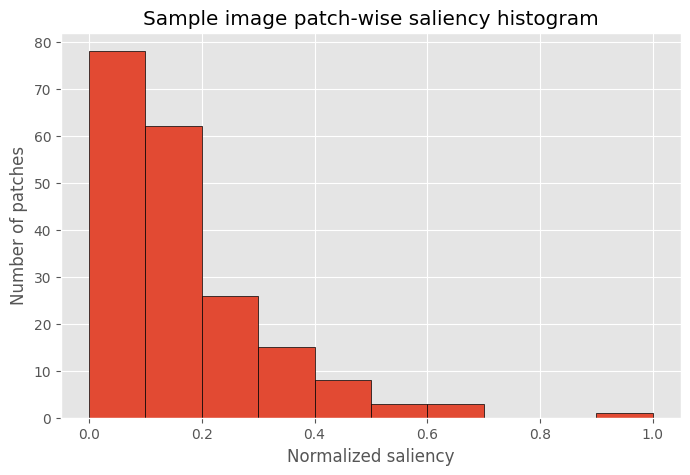

In [41]:
# ==============================
# Cell 7 — 단일 이미지에 대한 sanity check
# ==============================

if len(image_paths) == 0:
    raise RuntimeError("image_paths가 비어 있습니다. 데이터 경로/패턴을 확인하세요.")

# 샘플 이미지 선택 (원하면 인덱스를 바꾸면 됨)
sample_idx = 0
sample_path = image_paths[sample_idx]
print(f"샘플 이미지 경로: {sample_path}")

# 외부 target 사용 (없으면 None → argmax fallback)
sample_target = path_to_target.get(sample_path, None)

saliency_flat, pil_img, saliency_2d = get_patch_saliency_from_image(
    sample_path, teacher, target_class=sample_target
)

print(f"- saliency_flat shape: {saliency_flat.shape}")   # 예상: (196,)
print(f"- saliency_2d shape : {saliency_2d.shape}")      # 예상: (14, 14)")
print(f"- saliency min / max / mean: {saliency_flat.min():.4f} / {saliency_flat.max():.4f} / {saliency_flat.mean():.4f}")

# 샘플 이미지에 대한 histogram (로컬)
plt.figure()
plt.hist(saliency_flat, bins=BIN_EDGES, edgecolor="black")
plt.xlabel("Normalized saliency")
plt.ylabel("Number of patches")
plt.title("Sample image patch-wise saliency histogram")
plt.show()

# DEBUG 모드일 경우: 시각화 이미지 저장
if DEBUG_MODE:
    debug_name = os.path.splitext(os.path.basename(sample_path))[0]
    save_prefix = os.path.join(OUTPUT_DIR, f"debug_sample_{debug_name}")
    save_debug_visualizations(pil_img, saliency_2d, save_prefix)


In [42]:
# ==============================
# Cell 8 — 전체 데이터셋 saliency 수집
# ==============================

# tqdm이 있으면 progress bar 사용, 없으면 그냥 패스
try:
    from tqdm import tqdm
    use_tqdm = True
except ImportError:
    use_tqdm = False
    print("tqdm이 설치되어 있지 않습니다. progress bar 없이 실행합니다.")

all_saliency_vals = []
DEBUG_MAX_VIS = 10
debug_vis_count = 0

iterable = image_paths
if use_tqdm:
    iterable = tqdm(image_paths, desc="Computing saliency", ncols=80)

for img_idx, img_path in enumerate(iterable):
    try:
        # 외부 target 사용 (없으면 None → argmax)
        target_class = path_to_target.get(img_path, None)

        saliency_flat, pil_img, saliency_2d = get_patch_saliency_from_image(
            img_path, teacher, target_class=target_class
        )
        all_saliency_vals.append(saliency_flat)

        if DEBUG_MODE and debug_vis_count < DEBUG_MAX_VIS:
            fname = os.path.splitext(os.path.basename(img_path))[0]
            save_prefix = os.path.join(OUTPUT_DIR, f"debug_{img_idx:04d}_{fname}")
            save_debug_visualizations(pil_img, saliency_2d, save_prefix)
            debug_vis_count += 1

    except Exception as e:
        print(f"⚠️ 이미지 처리 중 오류 발생: {img_path}")
        print("   에러 메시지:", e)
        continue


# 리스트를 하나의 큰 1D numpy 배열로 합치기
if len(all_saliency_vals) == 0:
    raise RuntimeError("saliency를 수집하지 못했습니다. 앞 단계들을 확인하세요.")

all_saliency_vals = np.concatenate(all_saliency_vals, axis=0)  # shape: (N_patches_total,)
num_patches_total = all_saliency_vals.shape[0]

print("-" * 50)
print(f"총 패치 개수: {num_patches_total}")
print(f"saliency 값 예시 (앞 5개): {all_saliency_vals[:5]}")
print(f"min / max / mean: {all_saliency_vals.min():.4f} / {all_saliency_vals.max():.4f} / {all_saliency_vals.mean():.4f}")

# 결과를 파일로 저장 (재사용용)
saliency_save_path = os.path.join(OUTPUT_DIR, "all_saliency_vals.npy")
np.save(saliency_save_path, all_saliency_vals)
print(f"전체 saliency 벡터를 저장했습니다: {saliency_save_path}")


Computing saliency: 100%|███████████████████| 1600/1600 [00:59<00:00, 27.05it/s]

--------------------------------------------------
총 패치 개수: 313600
saliency 값 예시 (앞 5개): [0.46190846 0.25636968 0.1495695  0.16291048 0.12139852]
min / max / mean: 0.0000 / 1.0000 / 0.1842
전체 saliency 벡터를 저장했습니다: ./observation/06_Saliency_Analysis/SMI/all_saliency_vals.npy


all_saliency_vals shape: (313600,)
Histogram (counts per bin):
  [0.0, 0.1): 119353
  [0.1, 0.2): 90809
  [0.2, 0.3): 47223
  [0.3, 0.4): 24950
  [0.4, 0.5): 13364
  [0.5, 0.6): 7415
  [0.6, 0.7): 4173
  [0.7, 0.8): 2489
  [0.8, 0.9): 1402
  [0.9, 1.0): 2422


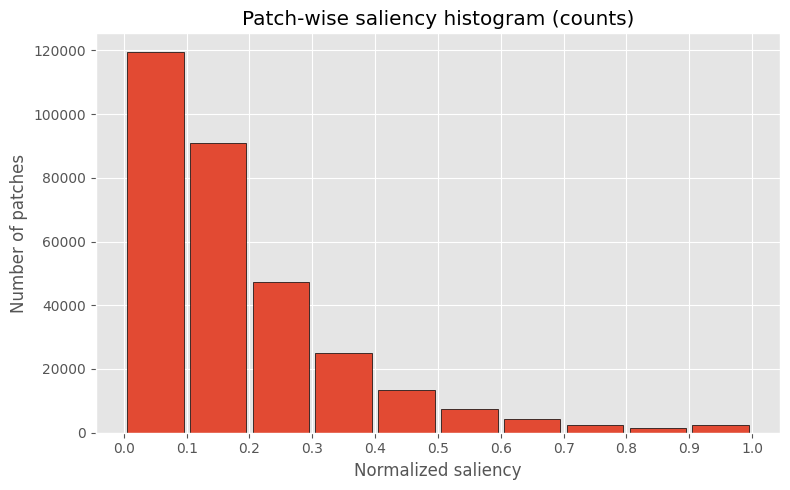

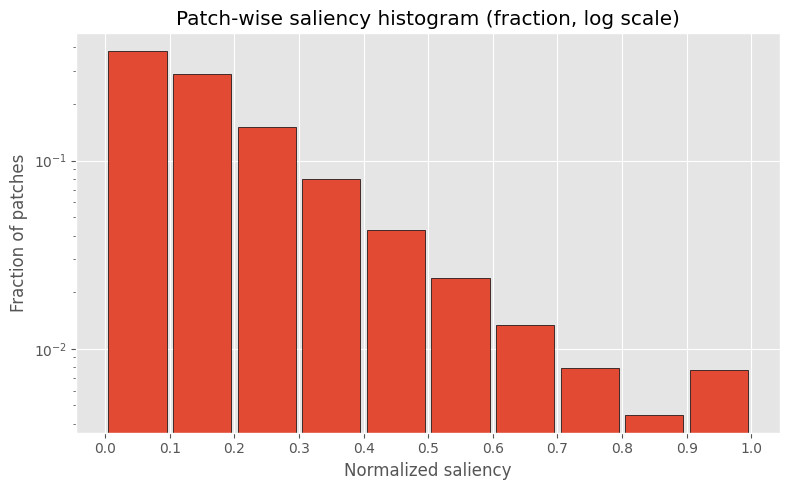

In [43]:
# ==============================
# Cell 9 — 전체 saliency histogram 시각화
# ==============================

# 혹시 노트북을 새로 켰을 때를 대비해서: 메모리에 없으면 파일에서 로드
if "all_saliency_vals" not in globals():
    saliency_save_path = os.path.join(OUTPUT_DIR, "all_saliency_vals.npy")
    if not os.path.isfile(saliency_save_path):
        raise FileNotFoundError(f"{saliency_save_path} 파일이 없습니다. Cell 8을 먼저 실행하세요.")
    all_saliency_vals = np.load(saliency_save_path)
    print(f"Loaded all_saliency_vals from: {saliency_save_path}")

print(f"all_saliency_vals shape: {all_saliency_vals.shape}")

# ------------------------------
# Histogram 계산
# ------------------------------
hist_counts, _ = np.histogram(all_saliency_vals, bins=BIN_EDGES)
bin_centers = 0.5 * (BIN_EDGES[:-1] + BIN_EDGES[1:])  # 각 bin의 중앙값

total_patches = all_saliency_vals.shape[0]
hist_probs = hist_counts / total_patches  # 비율(확률)로도 계산

print("Histogram (counts per bin):")
for c, left, right in zip(hist_counts, BIN_EDGES[:-1], BIN_EDGES[1:]):
    print(f"  [{left:.1f}, {right:.1f}): {c}")

# ------------------------------
# 1) 패치 수 기준 bar plot
# ------------------------------
plt.figure()
plt.bar(bin_centers, hist_counts, width=0.09, align="center", edgecolor="black")
plt.xlabel("Normalized saliency")
plt.ylabel("Number of patches")
plt.title("Patch-wise saliency histogram (counts)")
plt.xticks(BIN_EDGES)
plt.tight_layout()
plt.show()

# ------------------------------
# 2) 비율 기준 bar plot + y축 log scale
# ------------------------------
plt.figure()
plt.bar(bin_centers, hist_probs, width=0.09, align="center", edgecolor="black")
plt.xlabel("Normalized saliency")
plt.ylabel("Fraction of patches")
plt.title("Patch-wise saliency histogram (fraction, log scale)")
plt.yscale("log")  # long-tail 확인 용이
plt.xticks(BIN_EDGES)
plt.tight_layout()
plt.show()


all_saliency_vals shape: (313600,)
총 패치 수: 313600
saliency 총합: 5.775634e+04
--------------------------------------------------
상위 k% 패치가 차지하는 saliency 비율:
  상위 1% 패치 → saliency 5.19%
  상위 5% 패치 → saliency 19.07%
  상위 10% 패치 → saliency 31.40%


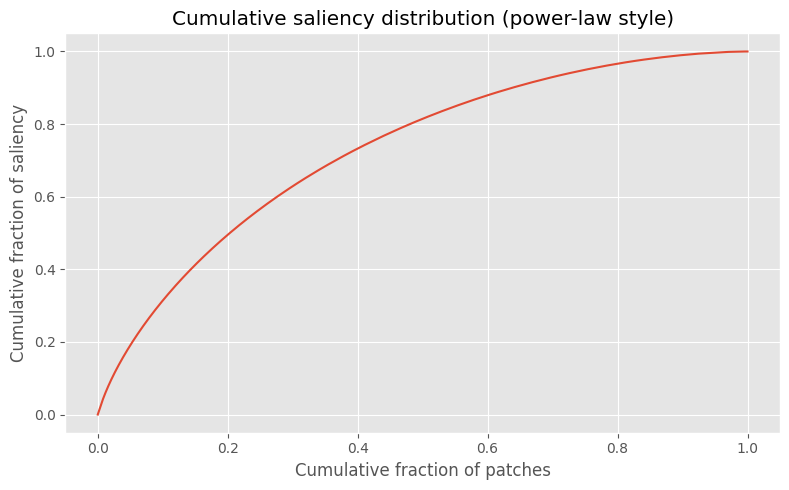

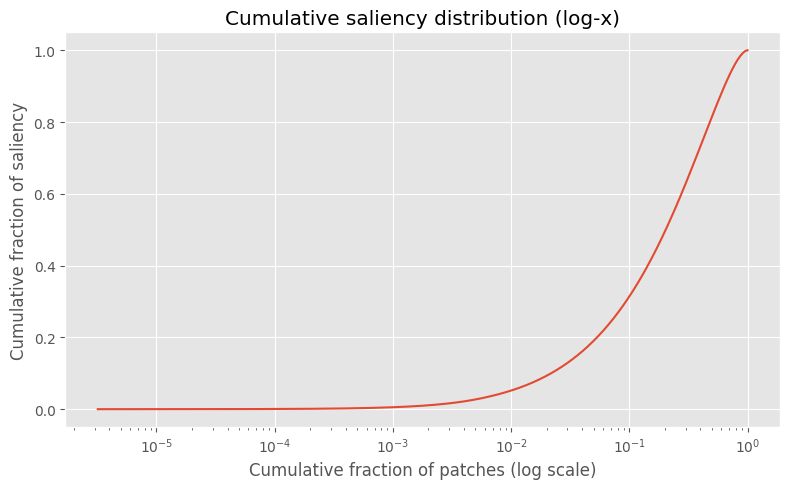

In [44]:
# ==============================
# Cell 10 — 누적 saliency(power-law) 곡선 분석
# ==============================

# 필요 시 파일에서 다시 로드
if "all_saliency_vals" not in globals():
    saliency_save_path = os.path.join(OUTPUT_DIR, "all_saliency_vals.npy")
    if not os.path.isfile(saliency_save_path):
        raise FileNotFoundError(f"{saliency_save_path} 파일이 없습니다. Cell 8을 먼저 실행하세요.")
    all_saliency_vals = np.load(saliency_save_path)
    print(f"Loaded all_saliency_vals from: {saliency_save_path}")

print(f"all_saliency_vals shape: {all_saliency_vals.shape}")

# ------------------------------
# 1) 내림차순 정렬 & 누적 합
# ------------------------------
vals_sorted = np.sort(all_saliency_vals)[::-1]          # 큰 값부터 정렬
cum_saliency = np.cumsum(vals_sorted)                  # 누적 합
total_saliency = cum_saliency[-1]
cum_saliency_norm = cum_saliency / total_saliency      # [0, 1] 범위

num_patches = len(vals_sorted)
cum_patch_ratio = np.arange(1, num_patches + 1) / num_patches  # 1/N ~ 1.0

print(f"총 패치 수: {num_patches}")
print(f"saliency 총합: {total_saliency:.6e}")

# ------------------------------
# 2) 상위 k% 패치가 차지하는 saliency 비율 계산
# ------------------------------
def saliency_share_for_top_fraction(fraction: float) -> float:
    """
    상위 fraction (예: 0.01 = 1%) 패치가 전체 saliency의 몇 %를 차지하는지 계산.
    """
    k = int(num_patches * fraction)
    k = max(k, 1)  # 최소 1개 이상
    share = cum_saliency[k - 1] / total_saliency
    return share

fractions = [0.01, 0.05, 0.10]
print("-" * 50)
print("상위 k% 패치가 차지하는 saliency 비율:")

for f in fractions:
    share = saliency_share_for_top_fraction(f)
    print(f"  상위 {int(f * 100)}% 패치 → saliency {share * 100:.2f}%")

# ------------------------------
# 3) 누적 곡선 시각화
# ------------------------------
plt.figure()
plt.plot(cum_patch_ratio, cum_saliency_norm)
plt.xlabel("Cumulative fraction of patches")
plt.ylabel("Cumulative fraction of saliency")
plt.title("Cumulative saliency distribution (power-law style)")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# 4) (옵션) x축 log-scale 버전: tail 구조를 더 잘 보기 위함
# ------------------------------
plt.figure()
plt.plot(cum_patch_ratio, cum_saliency_norm)
plt.xscale("log")
plt.xlabel("Cumulative fraction of patches (log scale)")
plt.ylabel("Cumulative fraction of saliency")
plt.title("Cumulative saliency distribution (log-x)")
plt.grid(True)
plt.tight_layout()
plt.show()


Total patches: 313600
------------------------------------------------------------
하위 k% 패치가 차지하는 saliency 비율:
  하위 1% 패치 → saliency 0.010%
  하위 5% 패치 → saliency 0.295%
  하위 10% 패치 → saliency 0.982%


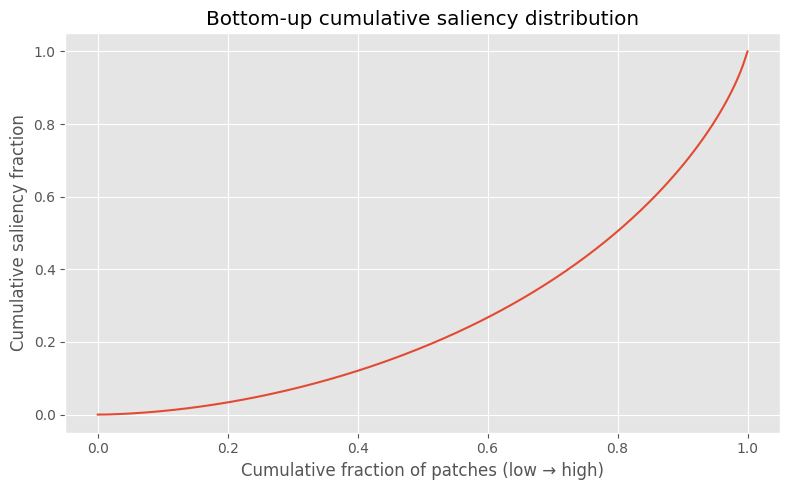

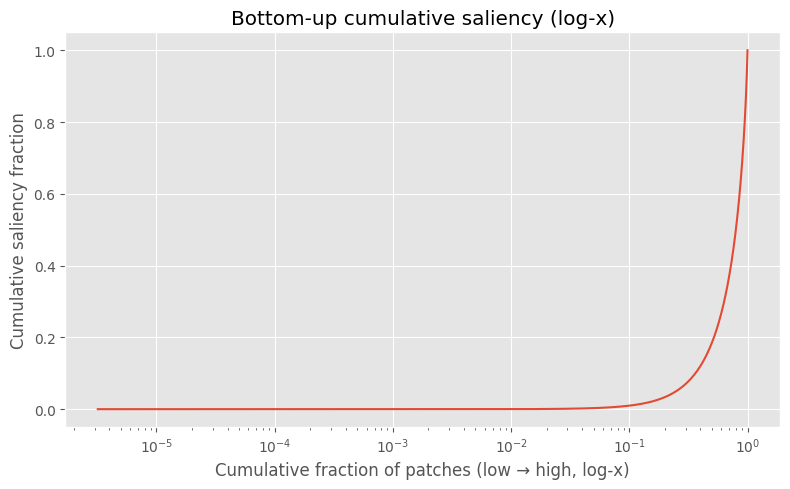

In [45]:
# ==============================
# Cell 10 (Bottom-up version)
# Saliency 누적을 값이 낮은 패치부터 계산
# ==============================

# 필요 시 재로드
if "all_saliency_vals" not in globals():
    path = os.path.join(OUTPUT_DIR, "all_saliency_vals.npy")
    all_saliency_vals = np.load(path)
    print(f"Loaded all_saliency_vals from: {path}")

print(f"Total patches: {len(all_saliency_vals)}")

# ------------------------------
# 1) saliency 오름차순 정렬 (low → high)
# ------------------------------
vals_sorted_low = np.sort(all_saliency_vals)  # 낮은 saliency부터

cum_saliency_low = np.cumsum(vals_sorted_low)
total_saliency = cum_saliency_low[-1]
cum_saliency_low_norm = cum_saliency_low / total_saliency  # [0,1]

num_patches = len(vals_sorted_low)
cum_patch_ratio = np.arange(1, num_patches + 1) / num_patches

# ------------------------------
# 2) 하위 k%의 saliency 비중 확인
# ------------------------------
def bottom_fraction_saliency(frac):
    k = max(int(num_patches * frac), 1)
    return cum_saliency_low[k - 1] / total_saliency

fractions = [0.01, 0.05, 0.10]
print("-" * 60)
print("하위 k% 패치가 차지하는 saliency 비율:")

for f in fractions:
    share = bottom_fraction_saliency(f)
    print(f"  하위 {int(f*100)}% 패치 → saliency {share*100:.3f}%")

# ------------------------------
# 3) 누적 곡선 시각화 (Bottom-up)
# ------------------------------
plt.figure()
plt.plot(cum_patch_ratio, cum_saliency_low_norm)
plt.xlabel("Cumulative fraction of patches (low → high)")
plt.ylabel("Cumulative saliency fraction")
plt.title("Bottom-up cumulative saliency distribution")
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------
# 4) log-x 시각화 (Bottom-up)
# ------------------------------
plt.figure()
plt.plot(cum_patch_ratio, cum_saliency_low_norm)
plt.xscale("log")
plt.xlabel("Cumulative fraction of patches (low → high, log-x)")
plt.ylabel("Cumulative saliency fraction")
plt.title("Bottom-up cumulative saliency (log-x)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [46]:
# ==============================
# Cell 11 — Saliency 분포 요약 통계
# ==============================

# 필요 시 재로드
if "all_saliency_vals" not in globals():
    path = os.path.join(OUTPUT_DIR, "all_saliency_vals.npy")
    all_saliency_vals = np.load(path)
    print(f"Loaded all_saliency_vals from: {path}")

vals = all_saliency_vals.astype(np.float64)
num_patches = len(vals)

print(f"총 패치 수: {num_patches}")
print(f"min / max / mean / median: {vals.min():.6f} / {vals.max():.6f} / {vals.mean():.6f} / {np.median(vals):.6f}")

# 분위수
percentiles = [0, 1, 5, 10, 25, 50, 75, 90, 95, 99, 100]
q_vals = np.percentile(vals, percentiles)

print("\n📊 Saliency 값 분위수(percentiles):")
for p, q in zip(percentiles, q_vals):
    print(f"  {p:3d} percentile: {q:.6f}")

# ------------------------------
# Top-down / Bottom-up 요약 수치 계산
# ------------------------------
vals_sorted_desc = np.sort(vals)[::-1]   # 큰 값부터
cum_desc = np.cumsum(vals_sorted_desc)
total_sal = cum_desc[-1]

vals_sorted_asc = np.sort(vals)         # 작은 값부터
cum_asc = np.cumsum(vals_sorted_asc)

def share_top(frac):
    k = max(int(num_patches * frac), 1)
    return cum_desc[k - 1] / total_sal

def share_bottom(frac):
    k = max(int(num_patches * frac), 1)
    return cum_asc[k - 1] / total_sal

fractions = [0.01, 0.05, 0.10]

print("\n🔥 상위 k% 패치가 차지하는 saliency 비율:")
for f in fractions:
    share = share_top(f) * 100
    print(f"  상위 {int(f*100):2d}% 패치 → saliency {share:6.2f}%")

print("\n🌱 하위 k% 패치가 차지하는 saliency 비율:")
for f in fractions:
    share = share_bottom(f) * 100
    print(f"  하위 {int(f*100):2d}% 패치 → saliency {share:6.4f}%")

# ------------------------------
# 사람이 읽기 좋은 요약 문장 생성
# ------------------------------
top_1 = share_top(0.01) * 100
top_5 = share_top(0.05) * 100
top_10 = share_top(0.10) * 100

bottom_50 = share_bottom(0.50) * 100
bottom_90 = share_bottom(0.90) * 100

print("\n📝 요약:")
print(f"- saliency 분포는 최소 {vals.min():.4f}, 최대 {vals.max():.4f}, 중앙값 {np.median(vals):.4f}입니다.")
print(f"- 상위 1% 패치가 전체 saliency의 약 {top_1:.2f}%를 차지합니다.")
print(f"- 상위 5% 패치가 전체 saliency의 약 {top_5:.2f}%를 차지합니다.")
print(f"- 상위 10% 패치가 전체 saliency의 약 {top_10:.2f}%를 차지합니다.")
print(f"- 반대로 하위 50% 패치는 전체 saliency의 약 {bottom_50:.4f}%만 담당합니다.")
print(f"- 하위 90% 패치는 전체 saliency의 약 {bottom_90:.4f}%만 담당합니다.")

print("\n→ 대부분의 패치는 saliency 기여도가 거의 없고, 소수의 패치에 saliency가 강하게 집중된 sparse한 분포임을 시사합니다.")


총 패치 수: 313600
min / max / mean / median: 0.000000 / 1.000000 / 0.184175 / 0.134113

📊 Saliency 값 분위수(percentiles):
    0 percentile: 0.000000
    1 percentile: 0.005514
    5 percentile: 0.018999
   10 percentile: 0.031523
   25 percentile: 0.067853
   50 percentile: 0.134113
   75 percentile: 0.245320
   90 percentile: 0.399441
   95 percentile: 0.524072
   99 percentile: 0.841056
  100 percentile: 1.000000

🔥 상위 k% 패치가 차지하는 saliency 비율:
  상위  1% 패치 → saliency   5.19%
  상위  5% 패치 → saliency  19.07%
  상위 10% 패치 → saliency  31.40%

🌱 하위 k% 패치가 차지하는 saliency 비율:
  하위  1% 패치 → saliency 0.0099%
  하위  5% 패치 → saliency 0.2954%
  하위 10% 패치 → saliency 0.9823%

📝 요약:
- saliency 분포는 최소 0.0000, 최대 1.0000, 중앙값 0.1341입니다.
- 상위 1% 패치가 전체 saliency의 약 5.19%를 차지합니다.
- 상위 5% 패치가 전체 saliency의 약 19.07%를 차지합니다.
- 상위 10% 패치가 전체 saliency의 약 31.40%를 차지합니다.
- 반대로 하위 50% 패치는 전체 saliency의 약 18.5332%만 담당합니다.
- 하위 90% 패치는 전체 saliency의 약 68.6021%만 담당합니다.

→ 대부분의 패치는 saliency 기여도가 거의 없고, 소수의 패치에 saliency가 강하게 집중된 s

Per-seed saliency:   0%|                                 | 0/50 [00:00<?, ?it/s]

Per-seed saliency: 100%|████████████████████████| 50/50 [00:43<00:00,  1.16it/s]

----------------------------------------------------------------------
Seed별 saliency 통계 요약:
seed |  #patches |     mean |   median |    top1% |    top5% |   top10%
----------------------------------------------------------------------
   1 |      6272 |   0.1758 |   0.1236 |    5.33% |   19.72% |   32.37%
   2 |      6272 |   0.1828 |   0.1289 |    5.23% |   19.20% |   31.79%
   3 |      6272 |   0.1691 |   0.1170 |    5.60% |   20.17% |   32.94%
   4 |      6272 |   0.1919 |   0.1436 |    4.89% |   18.30% |   30.56%
   5 |      6272 |   0.1872 |   0.1417 |    5.04% |   18.98% |   31.07%
   6 |      6272 |   0.1831 |   0.1340 |    5.16% |   19.13% |   31.37%
   7 |      6272 |   0.1909 |   0.1396 |    4.98% |   18.46% |   30.58%
   8 |      6272 |   0.1892 |   0.1355 |    5.05% |   19.22% |   31.87%
   9 |      6272 |   0.1824 |   0.1329 |    5.20% |   19.35% |   31.83%
  10 |      6272 |   0.1874 |   0.1381 |    5.01% |   18.54% |   30.87%
  11 |      6272 |   0.1760 |   0.1248 |    

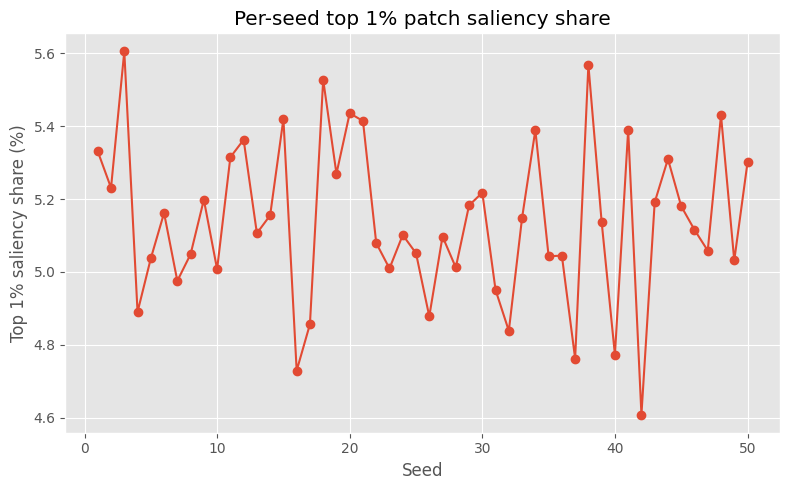

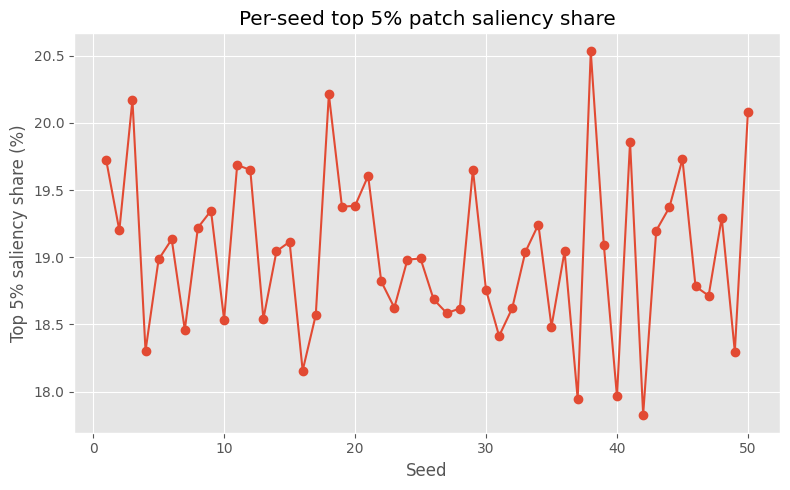

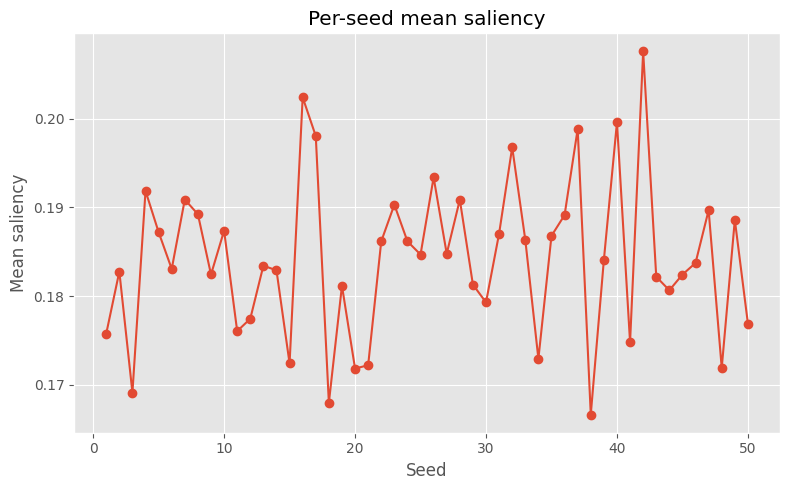

In [47]:
# ==============================
# Cell 12 — Seed별 saliency 분포 분석
# ==============================

# tqdm이 있으면 progress bar 사용
try:
    from tqdm import tqdm
    use_tqdm = True
except ImportError:
    use_tqdm = False
    print("tqdm이 설치되어 있지 않습니다. progress bar 없이 실행합니다.")

seed_list = []
num_patches_list = []
mean_list = []
median_list = []
top1_share_list = []
top5_share_list = []
top10_share_list = []

def compute_top_k_share(vals: np.ndarray, fractions=(0.01, 0.05, 0.10)):
    """
    vals: 1D saliency array (한 seed에 대한 모든 패치)
    fractions: (0.01, 0.05, 0.10) 등
    return: 각 fraction에 대한 top-k share 리스트
    """
    vals = vals.astype(np.float64)
    vals_sorted_desc = np.sort(vals)[::-1]
    cum_desc = np.cumsum(vals_sorted_desc)
    total_sal = cum_desc[-1]
    n = len(vals)

    shares = []
    for f in fractions:
        k = max(int(n * f), 1)
        share = cum_desc[k - 1] / total_sal
        shares.append(share)
    return shares  # [share_top1, share_top5, share_top10]

# Seed별로 다시 루프 돌면서 계산
seed_iter = SEED_RANGE
if use_tqdm:
    seed_iter = tqdm(SEED_RANGE, desc="Per-seed saliency", ncols=80)

for seed in seed_iter:
    # folder_name = f"DMI-4000-{seed}-32-W4A8"
    folder_name = f"SMI-4000-50-100-200-300-0.3-0.3-0.3-0.3-{seed}-32-W4A8"
    folder_path = os.path.join(BASE_DIR, folder_name)
    pattern = os.path.join(folder_path, "*.png")
    img_paths = sorted(glob.glob(pattern))

    if len(img_paths) == 0:
        print(f"⚠️ Seed {seed}: 이미지가 없습니다. ({folder_path})")
        continue

    seed_saliency_list = []

    for img_path in img_paths:
        try:
            target_class = path_to_target.get(img_path, None)

            saliency_flat, _, _ = get_patch_saliency_from_image(
                img_path, teacher, target_class=target_class
            )
            seed_saliency_list.append(saliency_flat)
        except Exception as e:
            print(f"  ⚠️ Seed {seed} - 이미지 처리 오류: {img_path}")
            print("     에러:", e)
            continue

    if len(seed_saliency_list) == 0:
        print(f"⚠️ Seed {seed}: saliency를 계산하지 못했습니다.")
        continue

    seed_vals = np.concatenate(seed_saliency_list, axis=0)  # 1D

    # 저장 (원하면 나중에 개별 seed 분석에 재사용)
    save_path = os.path.join(OUTPUT_DIR, f"saliency_seed_{seed}.npy")
    np.save(save_path, seed_vals)

    # 통계 계산
    mean_val = float(seed_vals.mean())
    median_val = float(np.median(seed_vals))
    top1, top5, top10 = compute_top_k_share(seed_vals, fractions=(0.01, 0.05, 0.10))

    # 기록
    seed_list.append(seed)
    num_patches_list.append(len(seed_vals))
    mean_list.append(mean_val)
    median_list.append(median_val)
    top1_share_list.append(top1)
    top5_share_list.append(top5)
    top10_share_list.append(top10)

# ------------------------------
# Seed별 요약 출력
# ------------------------------
print("-" * 70)
print("Seed별 saliency 통계 요약:")
print(f"{'seed':>4} | {'#patches':>9} | {'mean':>8} | {'median':>8} | {'top1%':>8} | {'top5%':>8} | {'top10%':>8}")
print("-" * 70)

for s, n_p, m, med, t1, t5, t10 in zip(seed_list, num_patches_list, mean_list, median_list,
                                       top1_share_list, top5_share_list, top10_share_list):
    print(f"{s:4d} | {n_p:9d} | {m:8.4f} | {med:8.4f} | {t1*100:7.2f}% | {t5*100:7.2f}% | {t10*100:7.2f}%")

# ------------------------------
# Seed vs 각 지표 라인 플롯
# ------------------------------
plt.figure()
plt.plot(seed_list, [x * 100 for x in top1_share_list], marker="o")
plt.xlabel("Seed")
plt.ylabel("Top 1% saliency share (%)")
plt.title("Per-seed top 1% patch saliency share")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(seed_list, [x * 100 for x in top5_share_list], marker="o")
plt.xlabel("Seed")
plt.ylabel("Top 5% saliency share (%)")
plt.title("Per-seed top 5% patch saliency share")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(seed_list, mean_list, marker="o")
plt.xlabel("Seed")
plt.ylabel("Mean saliency")
plt.title("Per-seed mean saliency")
plt.grid(True)
plt.tight_layout()
plt.show()
